In [1]:
#Import core libs
import re
import random
import math
import matplotlib.pyplot as plt
import datetime
import os
from operator import add

#Import non-core libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats as stats

#Import Visualization libs
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category20
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

#Import Prediction libs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score

## Definición de fuente

In [2]:
#Definimos la fuente del archivo (indicar directorio local)
source = "../../DataSets Grandes/properati2.csv"
data = pd.read_csv(source)
#Github repository = "https://github.com/Properati-Analysis/TP2"

## Análisis exploratorio de datos

In [3]:
#Analizamos las columnas
data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [4]:
#Analizamos la forma
data.shape

(121220, 26)

In [5]:
#Vemos los primeros datos
data.head(2)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [6]:
#Vemos los nulos del dataset
data.isna().sum()

Unnamed: 0                         0
operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
properati_url                      0
description                        2
title                              0
image_thumbnail                 3112
dtype: int64

## Limpieza de datos

In [7]:
df = data.drop(columns = ["operation","country_name","geonames_id","image_thumbnail","properati_url","lat-lon","price_aprox_local_currency","price_aprox_usd"])

In [8]:
df.shape

(121220, 18)

In [9]:
#df.corr()

In [10]:
#Guardo una copia del dataset con nulos
df_with_nan = df

In [11]:
#Hacemos limpieza de los registros que tengan nulo en alguno de los features expresados en el subset, ya que nos interesa tener todos completos, e inferirlos generaría un sesgo en el modelo
df = df.dropna(subset=['price','property_type', "surface_covered_in_m2","surface_total_in_m2","price_usd_per_m2"], how='any')
df = df.dropna(subset=["place_name"], how='any')

In [12]:
df.shape

(63334, 18)

In [13]:
df = df[df.currency == "USD"]

In [14]:
#Removemos los state_names con 30 o menos registros
value_counts_st = df['state_name'].value_counts()
to_remove_st = value_counts_st[value_counts_st <= 50].index
to_remove_st

Index(['Chubut', 'Entre Ríos', 'Misiones', 'Salta', 'Tucumán', 'Chaco',
       'Tierra Del Fuego', 'Santa Cruz', 'Catamarca', 'Santiago Del Estero',
       'La Pampa', 'Jujuy', 'San Juan'],
      dtype='object')

In [15]:
#Removemos los place_names con 5 o menos registros
value_counts_pl = df['place_name'].value_counts()
to_remove_pl = value_counts_pl[value_counts_pl <= 5].index
to_remove_pl

Index(['La Punta', 'Valle Claro', 'General Las Heras', 'Ricardo Rojas',
       'Prados del Oeste', 'Pehuajó', 'Miraflores Country Club', 'Don Bosco',
       'Altos del Golf', 'Rafael Calzada',
       ...
       'San Francisco del Monte', 'Barrio Cerrado El Casco de Alvarez',
       'Oberá', 'Barrio Parque Almirante Irízar', 'Bosque Peralta Ramos',
       'Barrio San Eduardo - Pilar del Este', 'El Molino', 'Monte Cristo',
       'Haras del Sol - Barrio Privado', 'Santo Tomé'],
      dtype='object', length=342)

In [16]:
df = df[~df.state_name.isin(to_remove_st)]
df = df[~df.place_name.isin(to_remove_pl)]

In [17]:
df.shape

(54998, 18)

In [18]:
df['state_name'].value_counts()

Capital Federal                 21319
Bs.As. G.B.A. Zona Norte        15616
Bs.As. G.B.A. Zona Sur           5325
Buenos Aires Costa Atlántica     4918
Bs.As. G.B.A. Zona Oeste         4082
Córdoba                          1274
Santa Fe                         1007
Buenos Aires Interior             698
Corrientes                        290
Mendoza                           224
Neuquén                            93
Río Negro                          77
San Luis                           75
Name: state_name, dtype: int64

In [19]:
#Filtros
apart = df.property_type == "apartment"
ph = df.property_type == "PH"
house = df.property_type == "house"
store = df.property_type == "store"

In [20]:
ap_price_ol = df[apart]["price_usd_per_m2"].quantile(0.75) + (1.5 * (df[apart]["price_usd_per_m2"].quantile(0.75) - df[apart]["price_usd_per_m2"].quantile(0.25)))
ap_sup_ol = df[apart]["surface_total_in_m2"].quantile(0.75) + (1.5 * (df[apart]["surface_total_in_m2"].quantile(0.75) - df[apart]["surface_total_in_m2"].quantile(0.25)))

In [21]:
ph_price_ol = df[ph]["price_usd_per_m2"].quantile(0.85) + (1.5 * (df[ph]["price_usd_per_m2"].quantile(0.75) - df[ph]["price_usd_per_m2"].quantile(0.25)))
ph_price_ol_min = df[ph]["price_usd_per_m2"].quantile(0.15) - (1.5 * (df[ph]["price_usd_per_m2"].quantile(0.75) - df[ph]["price_usd_per_m2"].quantile(0.25)))
ph_sup_ol = df[ph]["surface_total_in_m2"].quantile(0.85) + (1.5 * (df[ph]["surface_total_in_m2"].quantile(0.75) - df[ph]["surface_total_in_m2"].quantile(0.25)))
ph_sup_ol_min = df[ph]["surface_total_in_m2"].quantile(0.15) - (1.5 * (df[ph]["surface_total_in_m2"].quantile(0.75) - df[ph]["surface_total_in_m2"].quantile(0.25)))

In [22]:
ho_price_ol = df[house]["price_usd_per_m2"].quantile(0.75) + (1.5 * (df[house]["price_usd_per_m2"].quantile(0.75) - df[house]["price_usd_per_m2"].quantile(0.25)))
ho_sup_ol = df[house]["surface_total_in_m2"].quantile(0.75) + (1.5 * (df[house]["surface_total_in_m2"].quantile(0.75) - df[house]["surface_covered_in_m2"].quantile(0.25)))

In [23]:
st_price_ol = df[store]["price_usd_per_m2"].quantile(0.85) + (1.5 * (df[store]["price_usd_per_m2"].quantile(0.75) - df[store]["price_usd_per_m2"].quantile(0.25)))
st_sup_ol = df[store]["surface_total_in_m2"].quantile(0.85) + (1.5 * (df[store]["surface_total_in_m2"].quantile(0.75) - df[store]["surface_total_in_m2"].quantile(0.25)))

In [24]:
#Guardo copia para análisis exploratorio de los valores elevados
#df_high = df[df["surface_covered_in_m2"] > surface_covered_in_m2_ol]
df_high = df[df["price_usd_per_m2"] > ph_price_ol]

In [25]:
#Limpieza genérica, sin consideración de tipo de propiedad
surface_total_in_m2_ol = df["surface_total_in_m2"].quantile(0.75) + (1.5 * (df["surface_total_in_m2"].quantile(0.75) - df["surface_total_in_m2"].quantile(0.25)))

In [26]:
#Limpieza genérica, sin consideración de tipo de propiedad
#df = df[df["surface_covered_in_m2"] < surface_covered_in_m2_ol]

In [27]:
df_ap = df[apart]
df_ap = df_ap[df_ap.price_usd_per_m2 < ap_price_ol]
df_ap = df_ap[df_ap.surface_total_in_m2 < ap_sup_ol]
#df_ap.describe()

In [28]:
df_ph = df[ph]
df_ph = df_ph[df_ph.price_usd_per_m2 < ph_price_ol]
df_ph = df_ph[df_ph.price_usd_per_m2 > ph_price_ol_min]
df_ph = df_ph[df_ph.surface_total_in_m2 < ph_sup_ol]
df_ph = df_ph[df_ph.surface_total_in_m2 > ph_sup_ol_min]
#df_ph.describe()

In [29]:
df_ho = df[house]
df_ho = df_ho[df_ho.price_usd_per_m2 < ho_price_ol]
df_ho = df_ho[df_ho.surface_total_in_m2 < ho_sup_ol]
#df_ho.describe()

In [30]:
df_st = df[store]
df_st = df_st[df_st.price_usd_per_m2 < st_price_ol]
df_st = df_st[df_st.surface_total_in_m2 < st_sup_ol]
#df_st.describe()

In [31]:
df.shape

(54998, 18)

In [32]:
df_high.shape

(5886, 18)

In [33]:
frames = [df_ap,df_ph,df_ho,df_st]
df = pd.concat(frames)

In [34]:
#Nos quedamos solo con la superficie que guarda relación con la física
df = df[df.surface_covered_in_m2 < df.surface_total_in_m2]

In [35]:
df[df.property_type == "apartment"].isna().sum()

Unnamed: 0                     0
property_type                  0
place_name                     0
place_with_parent_names        0
state_name                     0
lat                         7179
lon                         7179
price                          0
currency                       0
surface_total_in_m2            0
surface_covered_in_m2          0
price_usd_per_m2               0
price_per_m2                   2
floor                      17626
rooms                      11438
expenses                   14529
description                    0
title                          0
dtype: int64

In [36]:
df.shape

(31841, 18)

<AxesSubplot:>

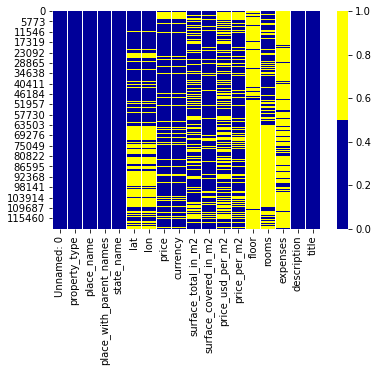

In [37]:
#Nulos sobre df inicial
cols = df_with_nan.columns[:30] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df_with_nan[cols].isnull(), cmap=sns.color_palette(colours))

<AxesSubplot:>

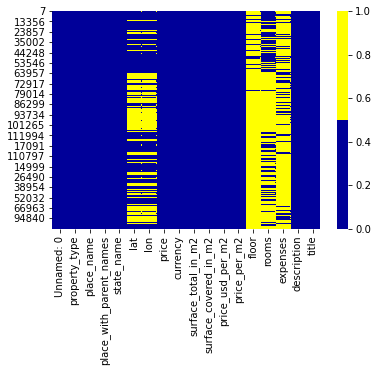

In [38]:
#Nulos sobre df limpio
cols = df.columns[:30] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [39]:
df_with_nan.property_type.value_counts()

apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

In [40]:
df.property_type.value_counts()

apartment    19459
house        10167
PH            1914
store          301
Name: property_type, dtype: int64

In [41]:
#df_high.property_type.value_counts()

<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='price'>

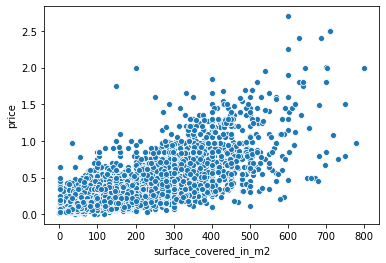

In [42]:
sns.scatterplot(x = "surface_covered_in_m2", y = df.price/1000000, data = df)

<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='price'>

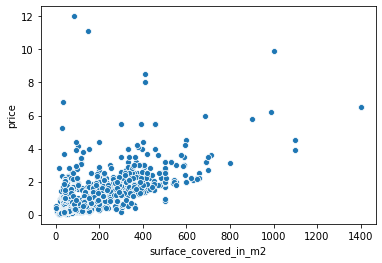

In [43]:
sns.scatterplot(x = "surface_covered_in_m2", y = df_high.price/1000000, data = df_high)

In [44]:
df["price"].max()

2700000.0

In [45]:
df_high["price"].max()

12000000.0

In [46]:
#Analizamos los propiedades con los valores más elevados
df[df["price"]==df["price"].max()].head()

,Unnamed: 0,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
50599,50599,house,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Bs.As. G.B.A. Zona Norte,NaN,NaN,2700000.0,USD,900.0,600.0,3000.0,4500.0,NaN,NaN,NaN,Extraordinaria casa A ESTRENAR. Desarrollada e...,"Casa 900m² con Dependencias, Bs.As. G.B.A. Zon..."


<AxesSubplot:xlabel='rooms', ylabel='price'>

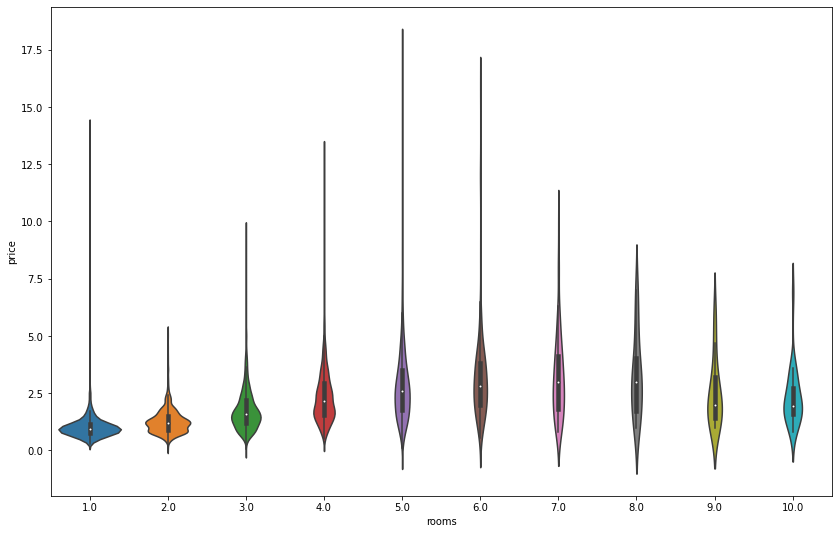

In [47]:
#Analizamos la distribución de los valores de las propiedades del dataset limpio, en relación a la cantidad de rooms
plt.figure(figsize=(14,9))
sns.violinplot(df.rooms[df.rooms<11],df.price/100000)

<AxesSubplot:xlabel='rooms', ylabel='price'>

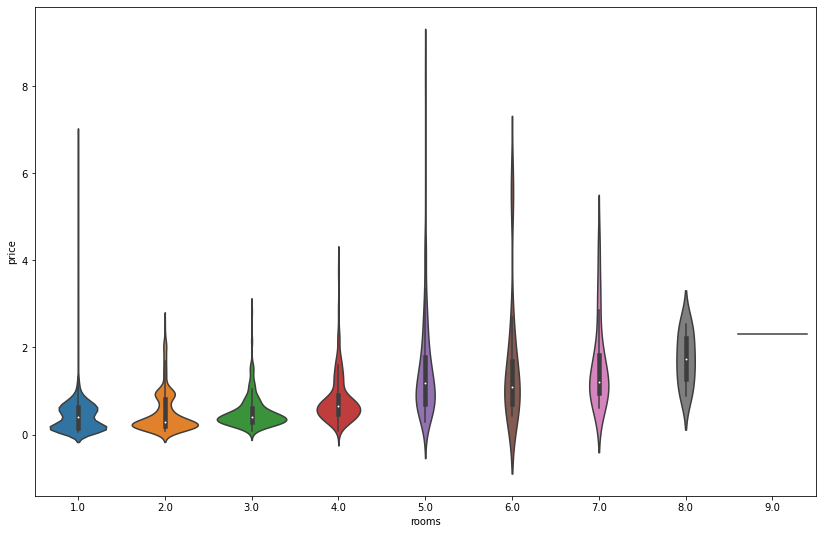

In [48]:
#Analizamos la distribución de los valores de las propiedades más caras en relación a la cantidad de rooms
plt.figure(figsize=(14,9))
sns.violinplot(df_high.rooms[df_high.rooms<10],df_high.price/1000000)

<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='price'>

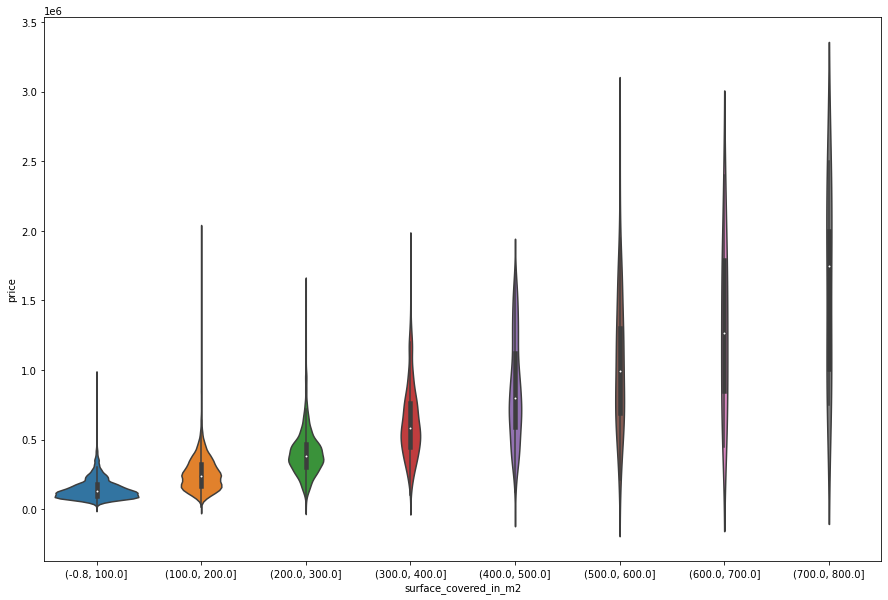

In [49]:
#Analizamos el valor de las propiedadse por rango de metros cuadrados cubiertos
plt.figure(figsize=(15,10))
sns.violinplot(pd.cut(df.surface_covered_in_m2,8),df.price)

In [50]:
#Generamos un df nuevo con menos variables para analizar la relación en un pairplot
df2 = df[["price","property_type","surface_covered_in_m2","rooms"]]

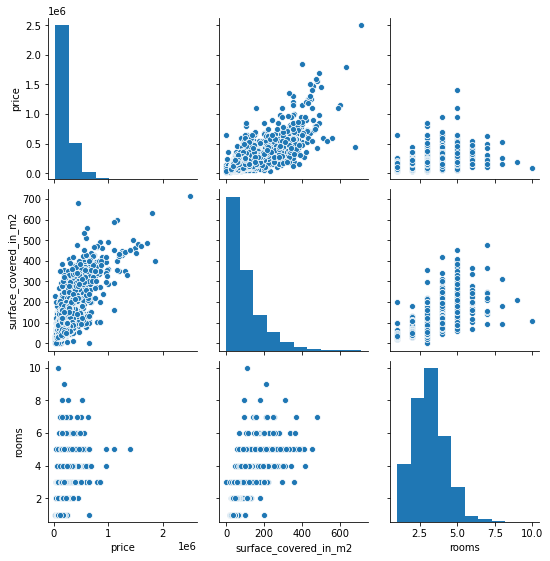

In [51]:
#Analizamos las propiedades del dataset limpio en el pairplot para evaluar si se mantiene una relación lineal de algún tipo
sns.pairplot(df2.sample(5000))

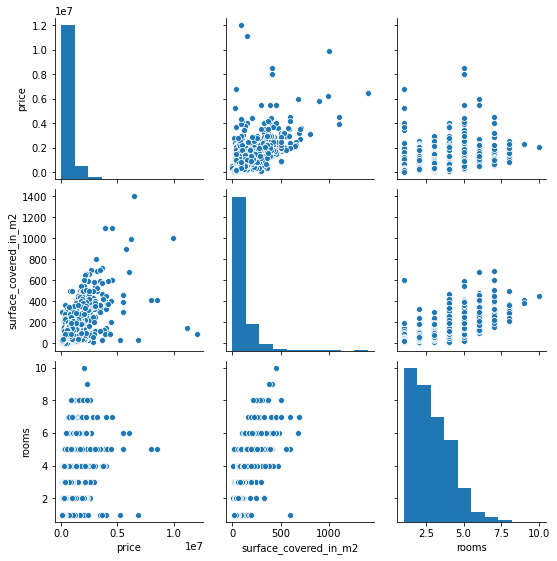

In [52]:
#Analizamos las propiedades más caras en el pairplot para evaluar si se mantiene una relación lineal de algún tipo
df3 = df_high[["price","property_type","surface_covered_in_m2","rooms"]]
sns.pairplot(df3)

<Figure size 1008x432 with 0 Axes>

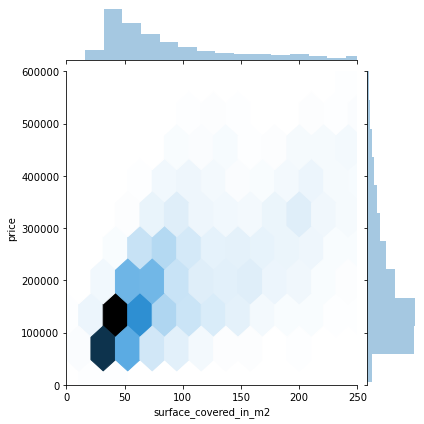

In [73]:
#Generamos un jointplot
plt.figure(figsize=(14,6))
sns.jointplot(x='surface_covered_in_m2', y='price', data=df, kind='hex', 
              gridsize=38, xlim = (0,250), ylim = (0,600000))

<Figure size 1008x720 with 0 Axes>

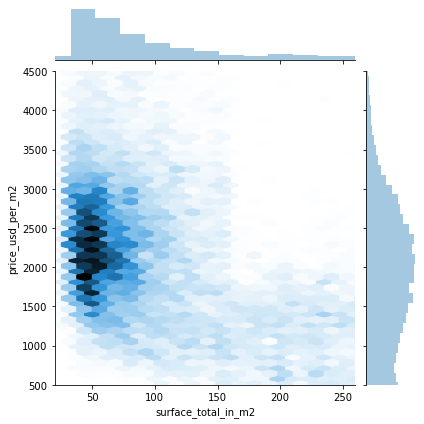

In [72]:
#Generamos un jointplot
plt.figure(figsize=(14,10))
sns.jointplot(x='surface_total_in_m2', y='price_usd_per_m2', data=df, kind='hex', 
              gridsize=80, xlim = (20,260), ylim = (500,4500))

## Regresión lineal múltiple

In [74]:
dummies = pd.get_dummies(df.loc[:,'property_type'], drop_first=True)
dummies_state = pd.get_dummies(df.loc[:,'state_name'], drop_first=True)
dummies_place_names = pd.get_dummies(df.loc[:,'place_name'], drop_first=True)

In [75]:
df_dummies  = pd.concat([df,dummies], axis = 1)
df_dummies_place  = pd.concat([df,dummies_state,dummies], axis = 1)

In [76]:
barrios = df_dummies.place_name.apply(lambda x: x in ["Belgrano", "Caballito", "Palermo", "Almagro", "Villa Crespo"])
df_prepared = pd.concat([df_dummies[barrios], pd.get_dummies(df[barrios].place_name, drop_first=True)], axis=1)
#df_prepared.head(3)

In [77]:
df_clean_dum = pd.concat([df, dummies, dummies_place_names], axis = 1)
#df_clean_dum.head(3)

In [78]:
df_dummies  = pd.concat([df,dummies], axis = 1)
df_dummies_place  = pd.concat([df,dummies_state,dummies], axis = 1)
df_dummies_place_names  = pd.concat([df_prepared,dummies_state,dummies,dummies_place_names], axis = 1)

In [79]:
v_counts = df[df.state_name == 'Capital Federal'].place_name.value_counts()
v_counts = v_counts[v_counts>100].index
v_counts

Index(['Caballito', 'Belgrano', 'Palermo', 'Villa Urquiza', 'Villa Crespo',
       'Flores', 'Almagro', 'San Telmo', 'Recoleta', 'Capital Federal',
       'Barrio Norte', 'Nuñez', 'Saavedra', 'Palermo Hollywood',
       'Villa del Parque', 'Villa Luro', 'Palermo Soho', 'Balvanera',
       'Floresta', 'Barracas', 'Monserrat', 'Mataderos', 'Villa Devoto',
       'Coghlan', 'Colegiales', 'San Cristobal', 'Parque Patricios', 'Liniers',
       'Chacarita', 'Boedo', 'Constitución', 'Villa Pueyrredón'],
      dtype='object')

In [80]:
feature_cols_dum = ["surface_total_in_m2","apartment","house","store"]
feature_cols_dum2 = ["surface_total_in_m2","apartment","house","store",'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Córdoba', 'Neuquén', 'San Luis', 'Santa Fe']
feature_cols_dum3 = ['surface_total_in_m2', 'apartment', 'house', 'store', "Belgrano", "Caballito", "Palermo", "Villa Crespo"]
feature_cols_dum4 = ["surface_total_in_m2","apartment","house","store", 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur',
                     'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Capital Federal', 'Córdoba', 'Neuquén', 'San Luis',
                     'Santa Fe', 'Caballito', 'Belgrano', 'Palermo', 'Villa Urquiza', 'Villa Crespo', 'Flores', 'Almagro', 'San Telmo', 
                     'Recoleta', 'Capital Federal', 'Barrio Norte', 'Nuñez', 'Saavedra', 'Palermo Hollywood', 'Villa del Parque', 'Villa Luro', 
                     'Palermo Soho', 'Balvanera', 'Floresta', 'Barracas', 'Monserrat', 'Mataderos', 'Villa Devoto', 'Coghlan', 'Colegiales', 
                     'San Cristobal', 'Parque Patricios', 'Liniers', 'Chacarita', 'Boedo', 'Constitución', 'Villa Pueyrredón']

In [81]:
df_dummies_place_names.head()

,Unnamed: 0,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,currency,surface_total_in_m2,...,Villa Santa Rita,Villa Sarmiento,Villa Soldati,Villa Tesei,Villa Udaondo,Villa Urquiza,Villa de Mayo,Villa del Parque,Virreyes,Wilde
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,7.0,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0,...,0,0,0,0,0,0,0,0,0,0
8,8.0,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0,...,0,0,0,0,0,0,0,0,0,0
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [82]:
X = df_dummies_place[feature_cols_dum]
y = df_dummies_place['price_usd_per_m2']

In [83]:
X2 = df_dummies_place[feature_cols_dum2]
y2 = df_dummies_place['price_usd_per_m2']

In [84]:
X3 = df_prepared[feature_cols_dum3]
y3 = df_prepared['price_usd_per_m2']

In [85]:
X4 = df_clean_dum[feature_cols_dum4]
y4 = df_clean_dum['price_usd_per_m2']

In [86]:
X5 = df_clean_dum[feature_cols_dum2]
y5 = df_clean_dum['price_usd_per_m2']

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels. api as sm

In [88]:
linreg = LinearRegression()

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

In [90]:
linreg.fit(X_train, y_train)

LinearRegression()

In [91]:
y_pred = linreg.predict(X_test)

In [92]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [93]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [94]:
print('El R2 de testeo del modelo es', r2_score(y_test, y_pred).round(2))
print('La media del error absoluto es', mae.round(2))
print('La media del error cuadrático es', mse.round(2))
print('La raíz del error cuadrático medio', rmse.round(2))

El R2 de testeo del modelo es 0.5
La media del error absoluto es 511.42
La media del error cuadrático es 430811.49
La raíz del error cuadrático medio 656.36


In [95]:
#np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [96]:
model = sm.OLS(y, sm.add_constant(X)).fit()
predictions = model.predict(sm.add_constant(X))

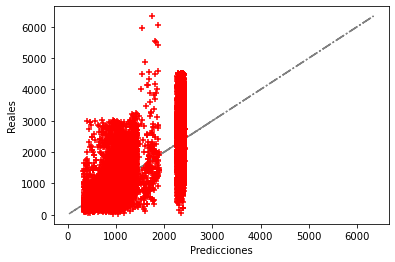

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     7927.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        01:13:05   Log-Likelihood:            -2.5183e+05
No. Observations:               31841   AIC:                         5.037e+05
Df Residuals:                   31836   BIC:                         5.037e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1476.9536     15.459     95.539      0.000    1446.653    1507.254
surface_total_in_m2    -1.1278      0.029    -39.194      0.000      -1.184      -1.071
apartment             970.4906     15.851     61.226      0.000     939.422    1001.559
house                 -59.0803     17.876     -3.305      0.001     -94.119     -24.042
store                 441.3089     41.094     10.739      0.000     360.762     521.856
==============================================================================
Omnibus:                     1859.856   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2402.336
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.744   Cond. No.                     2.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.show()

model.summary()

In [98]:
model_split = sm.OLS(y_train, sm.add_constant(X_train)).fit()
predictions_split = model_split.predict(sm.add_constant(X_test))

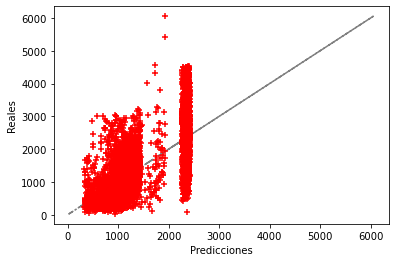

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     5143.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        01:13:06   Log-Likelihood:            -1.6372e+05
No. Observations:               20696   AIC:                         3.274e+05
Df Residuals:                   20691   BIC:                         3.275e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1483.3235     19.250     77.055      0.000    1445.592    1521.055
surface_total_in_m2    -1.1181      0.036    -31.324      0.000      -1.188      -1.048
apartment             963.1540     19.744     48.781      0.000     924.454    1001.854
house                 -70.1076     22.341     -3.138      0.002    -113.897     -26.318
store                 482.4351     52.450      9.198      0.000     379.628     585.242
==============================================================================
Omnibus:                     1204.172   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1550.395
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       3.737   Cond. No.                     3.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
plt.plot(y_test,y_test, '-.', c='grey')
plt.scatter(predictions_split, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.show()

model_split.summary()

In [100]:
#linreg = LinearRegression()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.35, random_state=10)

In [101]:
model = sm.OLS(y_train2, sm.add_constant(X_train2)).fit()
predictions = model.predict(sm.add_constant(X_test2))

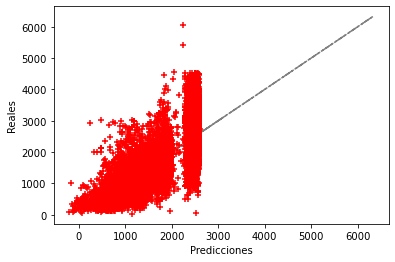

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     2261.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        01:13:07   Log-Likelihood:            -1.6171e+05
No. Observations:               20696   AIC:                         3.235e+05
Df Residuals:                   20682   BIC:                         3.236e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1613.3220     19.353     83.363      0.000    1575.389    1651.256
surface_total_in_m2             -1.2389      0.033    -37.785      0.000      -1.303      -1.175
apartment                      860.2419     18.066     47.618      0.000     824.832     895.652
house                           69.5370     20.608      3.374      0.001      29.144     109.930
store                          532.3798     47.667     11.169      0.000     438.949     625.810
Bs.As. G.B.A. Zona Oeste      -605.2133     16.954    -35.698      0.000    -638.444    -571.983
Bs.As. G.B.A. Zona Sur        -432.2156     15.980    -27.048      0.000    -463.537    -400.894
Buenos Aires Costa Atlántica  -526.1014     17.015    -30.920      0.000    -559.452    -492.750
Buenos Aires Interior         -663.6033     39.987    -16.596      0.000    -741.980    -585.226
Capital Federal                151.4032     11.078     13.667      0.000     129.689     173.118
Córdoba                       -698.4132     31.770    -21.983      0.000    -760.685    -636.141
Neuquén                       -370.8835    107.849     -3.439      0.001    -582.275    -159.492
San Luis                      -428.5384    141.464     -3.029      0.002    -705.819    -151.258
Santa Fe                      -559.5848     36.884    -15.171      0.000    -631.881    -487.289
==============================================================================
Omnibus:                     1707.519   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2623.654
Skew:                           0.645   Prob(JB):                         0.00
Kurtosis:                       4.175   Cond. No.                     8.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
plt.plot(y2,y2, '-.', c='grey')
plt.scatter(predictions, y_test2, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.show()

display (model.summary())

In [103]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.35, random_state=10)

In [104]:
linreg = LinearRegression()
linreg.fit(X_train4, y_train4)
y_pred4 = linreg.predict(X_test4)

mae = mean_absolute_error(y_test4, y_pred4)
mse = mean_squared_error(y_test4, y_pred4)
rmse = np.sqrt(mse)
r2 = r2_score(y_test4, y_pred4)

print('El R2 de testeo del modelo es', r2_score(y_test4, y_pred4).round(2))
print('La media del error absoluto es', mae.round(2))
print('La media del error cuadrático es', mse.round(2))
print('La raíz del error cuadrático medio', rmse.round(2))

El R2 de testeo del modelo es 0.6
La media del error absoluto es 447.74
La media del error cuadrático es 346131.19
La raíz del error cuadrático medio 588.33


In [105]:
model_split = sm.OLS(y_train4, sm.add_constant(X_train4)).fit()
predictions_split = model_split.predict(sm.add_constant(X_test4))

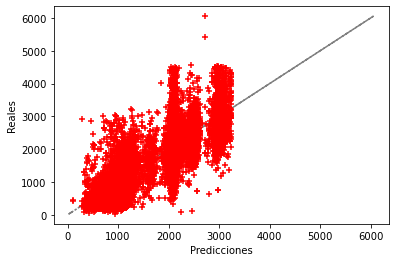

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     712.9
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        01:13:43   Log-Likelihood:            -1.6130e+05
No. Observations:               20696   AIC:                         3.227e+05
Df Residuals:                   20651   BIC:                         3.231e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1379.7134     17.711     77.903      0.000    1344.999    1414.428
surface_total_in_m2             -1.1177      0.032    -34.991      0.000      -1.180      -1.055
apartment                      821.5900     17.866     45.987      0.000     786.572     856.608
house                           24.3987     20.179      1.209      0.227     -15.153      63.950
store                          446.4525     46.828      9.534      0.000     354.667     538.238
Bs.As. G.B.A. Zona Oeste      -284.1660    185.919     -1.528      0.126    -648.581      80.249
Bs.As. G.B.A. Zona Sur        -664.8959    293.862     -2.263      0.024   -1240.889     -88.903
Buenos Aires Costa Atlántica  -767.2893    339.473     -2.260      0.024   -1432.683    -101.896
Buenos Aires Interior         -195.6303    177.270     -1.104      0.270    -543.093     151.832
Capital Federal                 66.9759     16.942      3.953      0.000      33.768     100.184
Córdoba                       -443.2995     38.347    -11.560      0.000    -518.462    -368.137
Neuquén                       -135.4615    587.655     -0.231      0.818   -1287.312    1016.389
San Luis                      -356.2484    262.901     -1.355      0.175    -871.554     159.058
Santa Fe                      -403.9230    222.176     -1.818      0.069    -839.406      31.560
Caballito                      366.5785     21.542     17.017      0.000     324.355     408.802
Belgrano                       835.5543     21.625     38.638      0.000     793.167     877.941
Palermo                        934.4316     23.655     39.503      0.000     888.067     980.796
Villa Urquiza                  405.4193     27.403     14.795      0.000     351.708     459.131
Villa Crespo                   423.6672     27.914     15.177      0.000     368.953     478.381
Flores                         -35.7787     28.271     -1.266      0.206     -91.193      19.635
Almagro                        125.3145     32.679      3.835      0.000      61.260     189.369
San Telmo                      251.1195     33.426      7.513      0.000     185.602     316.637
Recoleta                      1077.3656     33.122     32.527      0.000    1012.444    1142.287
Capital Federal                 66.9759     16.942      3.953      0.000      33.768     100.184
Barrio Norte                   824.7614     37.092     22.236      0.000     752.059     897.464
Nuñez                          811.2924     39.779     20.395      0.000     733.323     889.262
Saavedra                       316.8441     39.281      8.066      0.000     239.851     393.837
Palermo Hollywood              904.8229     42.791     21.145      0.000     820.949     988.697
Villa del Parque               318.5815     44.183      7.211      0.000    

In [106]:
plt.plot(y_test4,y_test4, '-.', c='grey')
plt.scatter(predictions_split, y_test4, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.show()

model_split.summary()

In [107]:
def train_test_rmse_reg(feature_cols, df, target='price'):
    X = df[feature_cols]
    y = df[target]
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    rlm = linear_model.RidgeCV(alphas=np.logspace(0.0001, 10, 500), normalize=True, cv=5)
    ridge_model = rlm.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    
    lassocv = linear_model.LassoCV(alphas=np.linspace(0.0001, 10, 500), cv=5, normalize=True)
    lasso_model = lassocv.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    return ((np.sqrt(metrics.mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)), 
            (np.sqrt(metrics.mean_squared_error(y_test, ridge_pred)),r2_score(y_test, ridge_pred)),
            (np.sqrt(metrics.mean_squared_error(y_test, lasso_pred)), r2_score(y_test, lasso_pred))
           )


In [108]:
def train_test_rmse_reg_ridge(feature_cols, df, target='price'):
    X = df[feature_cols]
    y = df[target]
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    rlm = linear_model.RidgeCV(alphas=np.logspace(0.0001, 10, 500), normalize=True, cv=5)
    ridge_model = rlm.fit(X_train, y_train)
    ridge_pred_train = ridge_model.predict(X_train)
    ridge_pred_test = ridge_model.predict(X_test)
    return (r2_score(y_train, ridge_pred_train),r2_score(y_test, ridge_pred_test))

In [133]:
df_dummies_place_names.isna().sum()

Unnamed: 0                            27199
property_type                         27199
place_name                            27199
place_with_parent_names               27199
state_name                            27199
                                      ...  
Village Golf & Tennis Country Club        0
Virrey del Pino                           0
Virreyes                                  0
Wilde                                     0
Zelaya                                    0
Length: 543, dtype: int64

In [161]:
train_test_rmse_reg(feature_cols_dum2,df_clean_dum,target = "price_usd_per_m2")

((596.6183772340592, 0.10862311067817554),
 (614.7849801838629, 0.05351308488925777),
 (596.6087576620549, 0.10865185466384586))

In [162]:
train_test_rmse_reg(feature_cols_dum,df_clean_dum,target = "price_usd_per_m2")

((590.4131502365827, 0.12706850925982127),
 (614.9356456084538, 0.05304911673329893),
 (590.4069390808207, 0.12708687566963794))

In [538]:
train_test_rmse_reg(feature_cols_dum4,df_clean_dum,target = "price_usd_per_m2")

((567.4260633354977, 0.1903019587533169),
 (597.1104569348048, 0.10336872747694914),
 (567.4200933424353, 0.19031899662511054))

In [109]:
train_test_rmse_reg(feature_cols_dum2,df_clean_dum,target = "price_usd_per_m2")

((594.6073131428075, 0.11087049742496624),
 (614.950844249309, 0.04898945509619146),
 (594.5975355043118, 0.1108997386239281))

In [134]:
train_test_rmse_reg(feature_cols_dum,df_dummies_place,target='price')

((120703.08231260377, 0.46660349522693545),
 (120692.13724245389, 0.4667002251092178),
 (120703.05417340712, 0.4666037439255951))

In [147]:
train_test_rmse_reg(feature_cols_dum3, df_prepared) #Con linspace en ridge

((96534.93770562712, 0.5156412837944383),
 (95398.45169315157, 0.5269786638566332),
 (96534.92948307339, 0.5156413663068529))

In [151]:
train_test_rmse_reg(feature_cols_dum3, df_prepared) #Con logspace en ridge

((96534.93770562712, 0.5156412837944383),
 (79385.31959176119, 0.6724493443181523),
 (96534.92948307339, 0.5156413663068529))

In [160]:
train_test_rmse_reg_ridge(feature_cols_dum3, df_prepared)

(0.5533480553302542, 0.6724493443181523)

In [540]:
train_test_rmse_reg_ridge(feature_cols_dum2,df_clean_dum,target = "price_usd_per_m2")

(0.3305982312673392, 0.04898945509619146)

## Ojo que llegó a 72%, antes estaba en 67%

In [542]:
train_test_rmse_reg_ridge(feature_cols_dum3, df_prepared)

(0.5948831163724895, 0.7243862295355427)

In [544]:
train_test_rmse_reg_ridge(feature_cols_dum4, df_clean_dum)

(0.17991192766784003, -0.06294668140106463)